# Modelagem de tópicos

## Bibliotecas utilizadas

In [1]:
import sys
import re
import os
import fnmatch

import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # não esqueça este
import matplotlib.pyplot as plt
%matplotlib inline

# Timer
import timeit
from timeit import default_timer as timer

import pickle

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Carrega dados anteriores

In [2]:
# Carrega corpora dictionary para o vocabulário
path = 'data/save/'
dict_name = 'rsc_dictionary'
dictfile = path + dict_name + '.dict'
id2word = corpora.Dictionary.load(dictfile)

# Carrega data_words gerados
data_words_processed = pickle.load(open('data/save/data_words_processed.pickle', 'rb'))

# Carrega lista com nomes dos arquivos
datafiles = pickle.load(open('data/save/datafiles.pickle', 'rb'))

# Carrega lista com os textos dos artigos
data = pickle.load(open('data/save/data.pickle', 'rb'))


In [3]:
# Carregando corpus
CORPUS_PATH = 'data/save/rsc_corpus.mm'
corpus = corpora.MmCorpus(CORPUS_PATH)

## Constrói o modelo LDA

In [4]:
# tdm pode ser usado como medidor de prograsso para iteráveis, no caso o corpus
from tqdm import tqdm

# Habilita log para análise da construção modelo
import logging
logging.basicConfig(filename='log/gensim_model_101_10t.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

numero_topicos = 10
start = timer()
lda_model = gensim.models.ldamodel.LdaModel(#corpus=corpus,
                                           corpus=tqdm(corpus),
                                           id2word=id2word,
                                           num_topics=numero_topicos,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           #passes=30,
                                           alpha='auto',
                                           eval_every=5,
                                           per_word_topics=True)

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

end = timer()
print('Tempo de execução (s) : ' + str(end - start)) # Intervalo de tempo, em segundos

100%|██████████| 44245/44245 [01:31<00:00, 484.99it/s]


Tempo de execução (s) : 758.907658


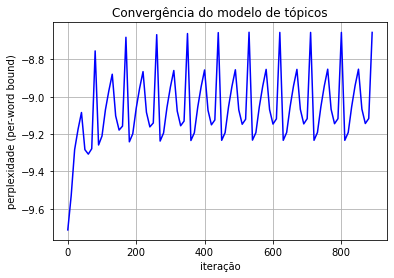

In [5]:
# Monitorando a convergência
# baseado em https://stackoverflow.com/questions/37570696/how-to-monitor-convergence-of-gensim-lda-model
import re
import matplotlib.pyplot as plt
p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('log/gensim_model_101_10t.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
likelihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter,likelihood,c="blue")
plt.ylabel("perplexidade (per-word bound)")
plt.xlabel("iteração")
plt.title("Convergência do modelo de tópicos")
plt.grid()
plt.savefig("tmp/convergence_likelihood.pdf")
plt.show()
plt.close()

## Mostra as palavras-chave de cada tópico

In [6]:
def keywords_repetidas_topicos(palavras):

    from collections import Counter
    import operator

    pd.set_option('display.max_rows', 200)

    counts_all = Counter(palavras)
    words, count_values = zip(*counts_all.items())

    # Classifica ambas as listas pela frequência dos valores (Schwartzian transform)
    # baseado eem http://stackoverflow.com/questions/9543211/sorting-a-list-in-python-using-the-result-from-sorting-another-list
    values_sorted, words_sorted = zip(*sorted(zip(count_values, words), key=operator.itemgetter(0), reverse=True))

    print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - - - - - - - - - - - -")
    print("As palavras-chave repetidas nos tópicos e suas respectivas frequências são:")

    # Usando um Pandas DataFrame para visualização
    df = pd.DataFrame({'Contagem': values_sorted, 'Palavra': words_sorted})
    df = df.loc[df['Contagem'] > 1]
    print("{0}".format(df[0:100]))
    sys.stdout.flush()

In [7]:
# Lista keywords de cada tópico 
def topics_simple(topic_keywords):
    print('Tópicos e palavras-chave\n')
    for topic,keywords in topic_keywords:
        line = str(topic) + ':'
        for idx, val in enumerate(keywords):
            if idx == 0:
                sep = ' '
            else:
                sep = ', '
            line = line + sep + val[0]
            #print(val[0])
            palavras.append(val[0])
        print(line)

In [8]:
# Obtém as palavras chaves do modelo e formata para uma visualização simples

# keywords dos tópicos
palavras = []

numero_topicos = 10
numero_words=10
topic_keyw = lda_model.show_topics(num_topics=numero_topicos, num_words=numero_words, log=False, formatted=False)
topics_simple(topic_keyw)

# imprime a lista de palavras repetidas
keywords_repetidas_topicos(palavras)

Tópicos e palavras-chave

0: plantas, agua, solo, uso, cafeina, frutos, lavoura, controle, produtividade, pesquisa
1: bebida, produto, empresa, marca, graos, mundo, coffee, casa, sabor, cafeterias
2: especiais, concurso, minas, fazenda, evento, mulheres, categoria, senar, especial, associacao
3: saca, safra, exportacao, dolar, volume, arabica, periodo, consumo, pais, preco
4: cnc, governo, nacional, recursos, credito, agricultura, rural, conselho, ministerio, federal
5: chuva, sul, area, minas_gerais, safra, parana, colheita, lavoura, norte, espirito_santo
6: colheita, cafeicultor, cooperativa, preco, safra, pandemia, momento, lavoura, cooxupe, saca
7: cafeicultura, empresa, evento, pesquisa, desenvolvimento, informacoes, produto, agronegocio, acoes, cafeicultor
8: dolar, pontos, alta, arabica, preco, queda, saca, cents_librap, negociado, baixa
9: rural, estado, rondonia, sindicato, curso, emater, municipio, agricultura, trabalhador, minas
- - - - - - - - - - - - - - - - - - - - - - - 

## Coleta métricas do modelo aplicado

In [9]:
# Calcula a preplexidade (Perplexity)
print('\nPerplexidade: ', lda_model.log_perplexity(corpus))  # mede o quanto um modelo é bom. Menor é melhor

# Calcula o score de coerência (Coherence Score)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_processed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de coerência: ', coherence_lda)


Perplexidade:  -9.081558924234272

Score de coerência:  0.6101929577104259


## Visualização (pyLDAvis) modelo Gensim LDA

In [10]:
# Visualização dos tópicos
# usando pyLDAvis (https://github.com/bmabey/pyLDAvis)

from IPython.core.display import HTML
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.098542 -0.252452       1        1  15.171542
6     -0.014078 -0.094620       2        1  13.472765
7      0.141882 -0.021155       3        1  12.966587
3     -0.220498 -0.002874       4        1  10.877191
8     -0.308829 -0.004459       5        1   9.627076
2      0.163159 -0.060225       6        1   9.620030
0      0.027997 -0.072300       7        1   9.619392
4      0.068793  0.113355       8        1   6.481035
9      0.204748  0.252200       9        1   6.444244
5     -0.161716  0.142530      10        1   5.720137, topic_info=             Term          Freq         Total Category  logprob  loglift
325          saca  64164.000000  64164.000000  Default  30.0000  30.0000
2024        dolar  40222.000000  40222.000000  Default  29.0000  29.0000
1849        chuva  24190.000000  24190.000000  Default  28.0000  28.0000
1119        rural  26779.000000  26779.000000  Default  27.0000  27.0000
4763       pontos  27110.000000  27110.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
2004  temperatura   1933.488859   3192.275003  Topic10  -5.4467   2.3598
766       periodo   2775.110429  16763.244333  Topic10  -5.0853   1.0627
659        estado   2881.006729  20550.596396  Topic10  -5.0479   0.8964
1042        media   2393.906557  11008.898293  Topic10  -5.2331   1.3354
565       cerrado   2109.127998   4998.861451  Topic10  -5.3597   1.9982

[724 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
8329      3  0.998152  acarpa
1161      1  0.020535   acoes
1161      2  0.008125   acoes
1161      3  0.786375   acoes
1161      5  0.019205   acoes
...     ...       ...     ...
1631      2  0.204259    zona
1631      5  0.010015    zona
1631      6  0.050076    zona
1631      9  0.109378    zona
1631     10  0.605399    zona

[1733 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 8, 4, 9, 3, 1, 5, 10, 6])

## Salva modelo gerado

In [11]:
from gensim.test.utils import datapath

# Salvando modelo lda_model.
model_path = datapath("C:\\Users\\rgosd\\Documents\\TCC\\peabirus\\data\\save\\models\\lda\\lda_model_10t")
#model_path = datapath("C:\\Users\\rgosd\\Documents\\TCC\\peabirus\\models\\lda\\lda_model")
lda_model.save(model_path)

In [12]:
# Carregando modelo treinado do disco (para validar recuperação)
model_path = datapath("C:\\Users\\rgosd\\Documents\\TCC\\peabirus\\data\\save\\models\\lda\\lda_model_10t")
lda_model = gensim.models.ldamodel.LdaModel.load(model_path)

## Constrói o modelo LDA Mallet

In [13]:
# Instando e preparando o Mallet
# Download do arquivo: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = 'path/to/mallet-2.0.8/bin/mallet' # atualizar conforme o ambiente de instalação
mallet_path = 'C:/mallet/bin/mallet'

In [14]:
numero_topicos = 10
start = timer()
ldamallet_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numero_topicos, id2word=id2word)
end = timer()

print('Tempo de execução (s) : ' + str(end - start)) # Intervalo de tempo, em segundos

Tempo de execução (s) : 746.801696


## Salva modelo gerado

In [15]:
from gensim.test.utils import datapath

# Salvando modelo ldamallet

model_path = datapath("C:\\Users\\rgosd\\Documents\\TCC\\peabirus\\data\\save\\models\\ldamallet\\ldamallet_model_10t")
ldamallet_model.save(model_path)

In [16]:
# Carregando modelo treinado do disco
ldamallet_model = gensim.models.ldamodel.LdaModel.load(model_path)

In [17]:
# Convertendo para ldamodel do Gensim (necessário para viisualização do pyLDAvis!)
# https://stackoverflow.com/questions/50340657/pyldavis-with-mallet-lda-implementation-ldamallet-object-has-no-attribute-inf
ldamallet_converted_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet_model)

## Visualização (pyLDAvis) modelo LDA Mallet

In [18]:
# Visualização dos tópicos
# usando pyLDAvis (https://github.com/bmabey/pyLDAvis)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamallet_converted_model, corpus, id2word)
vis

C:\Users\rgosd\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\rgosd\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\rgosd\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.109325 -0.281113       1        1  11.256426
0      0.236488  0.144702       2        1  10.822593
1      0.133178  0.154299       3        1  10.744328
4      0.186238  0.121644       4        1  10.670702
8      0.134877 -0.008602       5        1  10.390050
9      0.052064 -0.195473       6        1  10.361282
5     -0.220505 -0.036995       7        1   9.772758
6     -0.300854  0.086420       8        1   9.600290
7     -0.224742  0.134053       9        1   8.918331
2     -0.106069 -0.118935      10        1   7.463240, topic_info=                Term          Freq         Total Category  logprob  loglift
326            safra  41227.000000  41227.000000  Default  30.0000  30.0000
325             saca  63388.000000  63388.000000  Default  29.0000  29.0000
1849           chuva  25106.000000  25106.000000  Default  28.0000  28.0000
2024           dolar  34103.000000  34103.000000  Default  27.0000  27.0000
1083           preco  38320.000000  38320.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
657   espirito_santo   4363.349046  10452.122747  Topic10  -4.8988   1.7216
3722           forte   3566.787912   6903.377457  Topic10  -5.1003   1.9348
766          periodo   4370.873915  15712.062899  Topic10  -4.8970   1.3157
1672            pais   4728.842684  23768.858541  Topic10  -4.8183   0.9805
1042           media   3335.666935  10556.584502  Topic10  -5.1673   1.4431

[944 rows x 6 columns], token_table=       Topic      Freq                 Term
term                                       
3330       7  0.995913  abastecimento_conab
3330       9  0.004293  abastecimento_conab
3091       4  0.276561                 abic
3091       5  0.473484                 abic
3091       9  0.249889                 abic
...      ...       ...                  ...
65337      8  1.032317              xxxxxxx
65001      8  1.032317                 ying
1631       2  0.012912                 zona
1631       4  0.047998                 zona
1631      10  0.939190                 zona

[1448 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 9, 10, 6, 7, 8, 3])

In [19]:
# Obtém as palavras chaves do modelo e formata para uma visualização simples

# keywords dos tópicos
palavras = []

numero_topicos = 10
numero_words=10
topic_keyw = ldamallet_model.show_topics(num_topics=numero_topicos, num_words=numero_words, log=False, formatted=False)
topics_simple(topic_keyw)

# imprime a lista de palavras repetidas
keywords_repetidas_topicos(palavras)

Tópicos e palavras-chave

0: rural, cafeicultura, pesquisa, curso, embrapa, campo, estado, sindicato, desenvolvimento, agricultura
1: governo, agricultura, nacional, ministerio, recursos, rural, cnc, federal, cafeicultura, credito
2: chuva, area, sul, minas_gerais, centro, sao_paulo, norte, estado, tempo, lavoura
3: bebida, casa, graos, sabor, barista, leite, cafeteria, xicara, cidade, grao
4: especiais, evento, concurso, cafeicultor, minas, associacao, internacional, fazenda, cooperativa, minas_gerais
5: safra, preco, colheita, saca, cafeicultor, graos, arabica, conilon, lavoura, menor
6: dolar, arabica, alta, pontos, saca, preco, queda, tipo, cents_libra, cota
7: saca, exportacao, pais, dolar, consumo, mundial, periodo, paises, volume, aumento
8: empresa, produto, marca, mundo, consumidor, consumidores, maquinas, capsulas, starbucks, pais
9: agua, plantas, uso, cafeina, estudo, solo, controle, frutos, bebida, planta
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - - -

## Calcula o Score de Coerência

In [20]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet_model, texts=data_words_processed, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nScore de coerência: ', coherence_ldamallet)



Score de coerência:  0.6243076920418682


## Para cada tópico, mostra as palavras-chave e suas probabilidades

In [21]:
# mostra os tópicos
topic_keyw = ldamallet_model.show_topics(num_topics=numero_topicos, num_words=10, log=False, formatted=False)
pprint(topic_keyw)

[(0,
  [('rural', 0.020985767425869817),
   ('cafeicultura', 0.015365707342913707),
   ('pesquisa', 0.015109612220531813),
   ('curso', 0.011153585740997788),
   ('embrapa', 0.008949296673920746),
   ('campo', 0.008172825617931805),
   ('estado', 0.007789267626419194),
   ('sindicato', 0.007220946943873071),
   ('desenvolvimento', 0.006865454171251627),
   ('agricultura', 0.006377820993017608)]),
 (1,
  [('governo', 0.014041397117239814),
   ('agricultura', 0.01224912987553437),
   ('nacional', 0.010822173041274166),
   ('ministerio', 0.007738905913063216),
   ('recursos', 0.0070993171414519725),
   ('rural', 0.006520022320584119),
   ('cnc', 0.006158258616123785),
   ('federal', 0.0053637971475050126),
   ('cafeicultura', 0.004933463852003178),
   ('credito', 0.004890903416184315)]),
 (2,
  [('chuva', 0.04289973163559015),
   ('area', 0.03495901059681232),
   ('sul', 0.03488553642573874),
   ('minas_gerais', 0.01812607800385372),
   ('centro', 0.01492995156215272),
   ('sao_paulo', 0.

## Computa os valores de coerência para várias quantidades de tópicos 
(pode levar um bom tempo!)

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Calcula a coerência c_v para vários números de tópicos

    Parâmetros:
    dictionary : dicionário Gensim 
    corpus : corpus Gensim
    texts : lista de textos de entrada
    limit : número máximo de tópicos

    Retorna:
    model_list :  Lista de modelos de tópicos de LDA
    coherence_values : Valores de coerência correspondentes ao modelo de LDA com o respectivo número de tópicos
    """

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        start = timer()
        
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        end = timer()
        print('Tempo de execução (s) : ' + str(end - start)) # Intervalo de tempo, em segundos

    return model_list, coherence_values

In [23]:
# colocado este flag se não for desejado este processamento, devido à demora.
compute_coherence_values_enabled = False

if compute_coherence_values_enabled:
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_processed, start=2, limit=40, step=6)

In [24]:
if compute_coherence_values_enabled:
    # mostra grafico
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Número de tópicos")
    plt.ylabel("Score de coerência")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [25]:
if compute_coherence_values_enabled:
    # imprime os scores de coerência (coherence)
    for m, cv in zip(x, coherence_values):
        print("Num Topicos =", m, " tem um Coherence Value de ", round(cv, 4))

In [26]:
if compute_coherence_values_enabled:
    # seleciona um modelo e mostra os tópicos
    optimal_model = model_list[2]
    model_topics = optimal_model.show_topics(num_topics=40,formatted=False)
    pprint(optimal_model.print_topics(num_words=10))

## Fim